# Test regridding using two methods

* easygems Delaunay: https://easy.gems.dkrz.de/Processing/datasets/remapping.html
* earth2grid: https://github.com/NVlabs/earth2grid

In [1]:
# Make a .nc file we can use for testing.
from pathlib import Path
import iris

if not Path('/gws/nopw/j04/hrcm/mmuetz/Lorenzo_u-cu087/OLR/20200101T0000Z_pa000.nc').exists():
    cube = iris.load_cube('/gws/nopw/j04/hrcm/cache/torau/Lorenzo_u-cu087/OLR/20200101T0000Z_pa000.pp')
    iris.save(cube, '/gws/nopw/j04/hrcm/mmuetz/Lorenzo_u-cu087/OLR/20200101T0000Z_pa000.nc')

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr


In [5]:
ds = xr.open_dataset('/gws/nopw/j04/hrcm/mmuetz/Lorenzo_u-cu087/OLR/20200101T0000Z_pa000.nc')
ds

<xarray.Dataset> Size: 79MB
Dimensions:                     (latitude: 3840, longitude: 5120, bnds: 2)
Coordinates:
  * latitude                    (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                   (longitude) float32 20kB 0.03516 ... 360.0
    forecast_period             timedelta64[ns] 8B ...
    forecast_reference_time     datetime64[ns] 8B ...
    time                        datetime64[ns] 8B ...
Dimensions without coordinates: bnds
Data variables:
    toa_outgoing_longwave_flux  (latitude, longitude) float32 79MB ...
    latitude_longitude          int32 4B ...
    forecast_period_bnds        (bnds) float64 16B ...
    time_bnds                   (bnds) datetime64[ns] 16B ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.7
    Conventions:  CF-1.7

In [6]:
ds_coarse = ds.coarsen(dim={'latitude': 8, 'longitude': 8}).mean()
ds_coarse

<xarray.Dataset> Size: 1MB
Dimensions:                     (latitude: 480, longitude: 640, bnds: 2)
Coordinates:
  * latitude                    (latitude) float32 2kB -89.81 -89.44 ... 89.81
  * longitude                   (longitude) float32 3kB 0.2812 0.8438 ... 359.7
    forecast_period             timedelta64[ns] 8B 12:00:00
    forecast_reference_time     datetime64[ns] 8B 2020-01-01
    time                        datetime64[ns] 8B 2020-01-01T12:00:00
Dimensions without coordinates: bnds
Data variables:
    toa_outgoing_longwave_flux  (latitude, longitude) float32 1MB 186.0 ... 1...
    latitude_longitude          int32 4B -2147483647
    forecast_period_bnds        (bnds) float64 16B 0.0 24.0
    time_bnds                   (bnds) datetime64[ns] 16B 2020-01-01 2020-01-02
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.7
    Conventions:  CF-1.7

## easygems Delaunay

In [7]:
import healpix as hp
import numpy as np
import xarray as xr

import easygems.healpix as egh
import easygems.remap as egr

In [8]:
order = zoom = 5
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
hp_lon = hp_lon % 360  # [0, 360)
hp_lon += 360 / (4 * nside) / 4  # shift quarter-width

In [9]:
ds_flat = ds_coarse.stack(cell=('longitude', 'latitude'))
print(ds_flat)

<xarray.Dataset> Size: 6MB
Dimensions:                     (cell: 307200, bnds: 2)
Coordinates:
    forecast_period             timedelta64[ns] 8B 12:00:00
    forecast_reference_time     datetime64[ns] 8B 2020-01-01
    time                        datetime64[ns] 8B 2020-01-01T12:00:00
  * cell                        (cell) object 2MB MultiIndex
  * longitude                   (cell) float32 1MB 0.2812 0.2812 ... 359.7 359.7
  * latitude                    (cell) float32 1MB -89.81 -89.44 ... 89.44 89.81
Dimensions without coordinates: bnds
Data variables:
    toa_outgoing_longwave_flux  (cell) float32 1MB 186.0 186.7 ... 167.1 166.7
    latitude_longitude          int32 4B -2147483647
    forecast_period_bnds        (bnds) float64 16B 0.0 24.0
    time_bnds                   (bnds) datetime64[ns] 16B 2020-01-01 2020-01-02
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.7
    Conventions:  CF-1.7


In [10]:
weights = egr.compute_weights_delaunay((ds_flat.longitude.values, ds_flat.latitude.values), (hp_lon, hp_lat))

In [11]:
print(weights)

<xarray.Dataset> Size: 455kB
Dimensions:  (tgt_idx: 12288, tri: 3)
Dimensions without coordinates: tgt_idx, tri
Data variables:
    src_idx  (tgt_idx, tri) int32 147kB 39123 38642 39122 ... 269037 269516
    weights  (tgt_idx, tri) float64 295kB 0.6833 0.25 0.06667 ... 0.25 0.6833
    valid    (tgt_idx) bool 12kB True True True True ... True True True True


In [12]:
#%%timeit

olr_hp_z5 = egr.apply_weights(ds_flat.toa_outgoing_longwave_flux.values, **weights)

<Figure size 640x480 with 0 Axes>

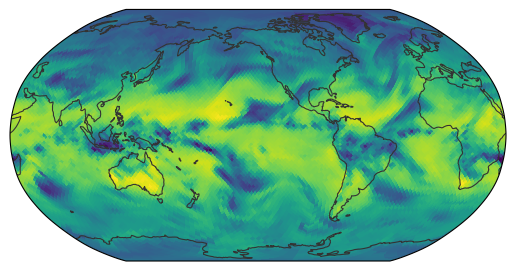

In [13]:
egh.healpix_show(olr_hp_z5);

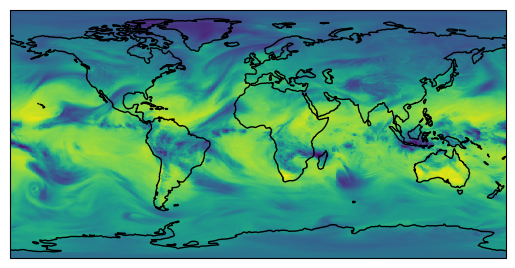

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolormesh(ds_coarse.longitude, ds_coarse.latitude, ds_coarse.toa_outgoing_longwave_flux)
ax.coastlines();


In [15]:
%%timeit
# I had to add on_missing_core_dim='copy' ('drop' also works...) and make sure that input_core_dims != output_core_dims.

ds_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds_flat,
    kwargs=weights,
    keep_attrs=True,
    input_core_dims=[["cell"]],
    output_core_dims=[["hpcell"]],
    on_missing_core_dim='copy',
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
ds_remap

2.07 ms ± 35.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
egh.healpix_show(ds_remap.toa_outgoing_longwave_flux);

NameError: name 'ds_remap' is not defined

## earth2grid

In [17]:
import torch

import earth2grid


/home/users/mmuetz/miniforge3/envs/regrid2hp_env/lib/python3.12/site-packages/earth2grid/healpix.py:60: UserWarning: healpixpad_cuda module not available, reverting to CPU for all padding routines
  warnings.warn("healpixpad_cuda module not available, reverting to CPU for all padding routines")


In [18]:
class E2G:
    def __init__(self, ds):
        self.ds = ds
        self.weights_latlon2hpx = {}
        
    def calc_weights_latlon2hpx(self, zoom):
        lat_lon_shape = (len(self.ds.latitude), len(self.ds.longitude))
        src = earth2grid.latlon.equiangular_lat_lon_grid(*lat_lon_shape)
        hpx = earth2grid.healpix.Grid(level=zoom, pixel_order=earth2grid.healpix.PixelOrder.NEST)
        self.weights_latlon2hpx[zoom] = earth2grid.get_regridder(src, hpx)

    def latlon2hpx(self, var, zoom):
        regridder = self.weights_latlon2hpx[zoom]
        z_torch = torch.as_tensor(self.ds[var].values.astype(float)[::-1].copy())
        z_hpx = regridder(z_torch)
        return z_hpx.numpy()

        


In [19]:
e2g = E2G(ds_coarse)
e2g.calc_weights_latlon2hpx(5)

In [20]:
o = e2g.latlon2hpx('toa_outgoing_longwave_flux', 5)

<Figure size 640x480 with 0 Axes>

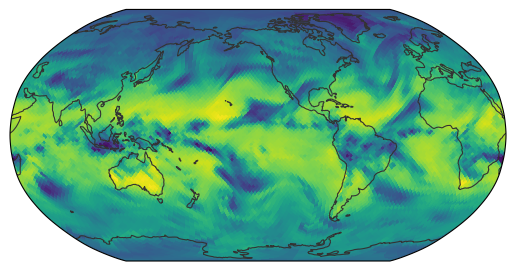

In [21]:
egh.healpix_show(o);

In [22]:
lat_lon_shape = (len(ds_coarse.latitude), len(ds_coarse.longitude))
src = earth2grid.latlon.equiangular_lat_lon_grid(*lat_lon_shape)

In [23]:
hpx = earth2grid.healpix.Grid(level=5, pixel_order=earth2grid.healpix.PixelOrder.NEST)

In [24]:
regrid = earth2grid.get_regridder(src, hpx)

In [25]:
#%%timeit
z_torch = torch.as_tensor(ds_coarse.toa_outgoing_longwave_flux.values.astype(float)[::-1].copy())
z_hpx = regrid(z_torch)
old_hpx = z_hpx.numpy()

<Figure size 640x480 with 0 Axes>

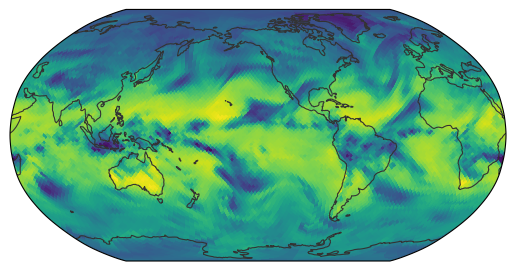

In [26]:
egh.healpix_show(z_hpx.numpy());

# Comparison

In [27]:
class EGDelaunay:
    def __init__(self, ds):
        self.ds = ds
        self.ds_flat = ds.stack(cell=('longitude', 'latitude'))
        self.weights_latlon2hpx = {}
        
    def calc_weights_latlon2hpx(self, zoom):
        print('Calculating weights (can take a while and/or use lots of RAM)')
        nside = hp.order2nside(zoom)
        npix = hp.nside2npix(nside)

        hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
        hp_lon = hp_lon % 360  # [0, 360)
        hp_lon += 360 / (4 * nside) / 4  # shift quarter-width
        self.weights_latlon2hpx[zoom] = (
            nside,
            npix,
            egr.compute_weights_delaunay((self.ds_flat.longitude.values, self.ds_flat.latitude.values), (hp_lon, hp_lat))
        )

    def latlon2hpx(self, var, zoom, method='func'):
        weights = self.weights_latlon2hpx[zoom][2]
        if method == 'func':
            return egr.apply_weights(self.ds_flat[var].values, **weights)
        elif method == 'xr_apply_ufunc':
            return xr.apply_ufunc(
                egr.apply_weights,
                self.ds_flat,
                kwargs=weights,
                keep_attrs=True,
                input_core_dims=[["cell"]],
                output_core_dims=[["hpcell"]],
                on_missing_core_dim='copy',
                output_dtypes=["f4"],
                vectorize=True,
                dask="parallelized",
                dask_gufunc_kwargs={
                    "output_sizes": {"cell": npix},
                },
            )


In [28]:
class E2G:
    def __init__(self, ds):
        self.ds = ds
        self.weights_latlon2hpx = {}
        
    def calc_weights_latlon2hpx(self, zoom):
        lat_lon_shape = (len(self.ds.latitude), len(self.ds.longitude))
        src = earth2grid.latlon.equiangular_lat_lon_grid(*lat_lon_shape)
        hpx = earth2grid.healpix.Grid(level=zoom, pixel_order=earth2grid.healpix.PixelOrder.NEST)
        self.weights_latlon2hpx[zoom] = earth2grid.get_regridder(src, hpx)

    def latlon2hpx(self, var, zoom):
        regridder = self.weights_latlon2hpx[zoom]
        z_torch = torch.as_tensor(self.ds[var].values.astype(float)[::-1].copy())
        z_hpx = regridder(z_torch)
        return z_hpx.numpy()

        


In [29]:
ds_coarse = ds.coarsen(dim={'latitude': 2, 'longitude': 2}).mean()
egd = EGDelaunay(ds_coarse)
e2h = E2G(ds_coarse)

In [30]:
for z in range(10):
    print(z)
    egd.calc_weights_latlon2hpx(z)
    e2h.calc_weights_latlon2hpx(z)

0
Calculating weights (can take a while and/or use lots of RAM)
1
Calculating weights (can take a while and/or use lots of RAM)
2
Calculating weights (can take a while and/or use lots of RAM)
3
Calculating weights (can take a while and/or use lots of RAM)
4
Calculating weights (can take a while and/or use lots of RAM)
5
Calculating weights (can take a while and/or use lots of RAM)
6
Calculating weights (can take a while and/or use lots of RAM)
7
Calculating weights (can take a while and/or use lots of RAM)
8
Calculating weights (can take a while and/or use lots of RAM)
9
Calculating weights (can take a while and/or use lots of RAM)


In [31]:
from timeit import default_timer as timer

nreps = 10
times = np.zeros((10, 3))
for z in range(10):
    print(z)
    for idx, regridder, kwargs in [(0, egd, {'method': 'func'}), (1, egd, {'method': 'xr_apply_ufunc'}), (2, e2h, {})]:
        print(regridder, kwargs)
        start = timer()
        for _ in range(nreps):
            regridder.latlon2hpx('toa_outgoing_longwave_flux', z, **kwargs)
        end = timer()
        times[z, idx] = (end - start) / nreps
    

0
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func'}
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'xr_apply_ufunc'}
<__main__.E2G object at 0x7fdc6a3589b0> {}
1
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func'}
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'xr_apply_ufunc'}
<__main__.E2G object at 0x7fdc6a3589b0> {}
2
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func'}
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'xr_apply_ufunc'}
<__main__.E2G object at 0x7fdc6a3589b0> {}
3
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func'}
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'xr_apply_ufunc'}
<__main__.E2G object at 0x7fdc6a3589b0> {}
4
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func'}
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'xr_apply_ufunc'}
<__main__.E2G object at 0x7fdc6a3589b0> {}
5
<__main__.EGDelaunay object at 0x7fdc6a08e0c0> {'method': 'func

In [32]:
times

array([[0.00072777, 0.00159584, 0.04644246],
       [0.00075116, 0.00156508, 0.03783513],
       [0.00067999, 0.00147388, 0.03795589],
       [0.00080388, 0.00152208, 0.03756194],
       [0.00126042, 0.00206748, 0.0402443 ],
       [0.00729719, 0.00892064, 0.04104368],
       [0.00997691, 0.01095944, 0.04785217],
       [0.02744444, 0.01650129, 0.06907693],
       [0.06301046, 0.04932638, 0.15362569],
       [0.17473313, 0.16589394, 0.33212289]])

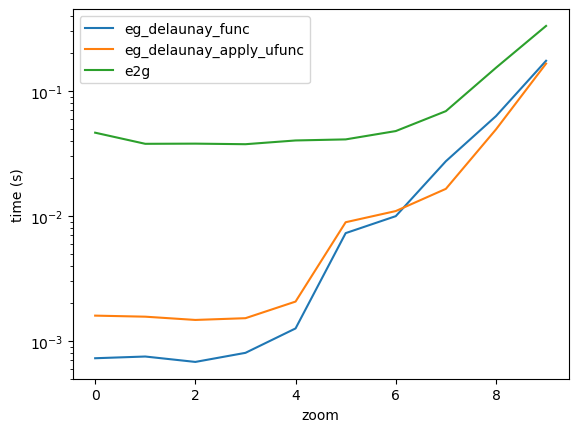

In [33]:
fig, ax = plt.subplots()
ax.plot(times[:, 0], label='eg_delaunay_func')
ax.plot(times[:, 1], label='eg_delaunay_apply_ufunc')
ax.plot(times[:, 2], label='e2g')
ax.set_yscale('log')
ax.set_ylabel('time (s)')
ax.set_xlabel('zoom')
ax.legend();